In [12]:
import os
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import describe
import multiprocessing

In [13]:
from thinning import sample_hawkes_process_thinning_true_vectorised
from utils import exp_kernel_vectorised, constant_background, plot_counting_process
from mle import log_likelihood

In [16]:
stan_file = os.path.join('.', 'simple_exp_hawkes_v2.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                force_compile=True
                                )

18:12:44 - cmdstanpy - INFO - compiling stan file C:\Users\ethan\ONEDRI~1\Maths\YEAR4~1\Project\HAWKES~1\simple_exp_hawkes_v2.stan to exe file C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\simple_exp_hawkes_v2.exe
18:13:09 - cmdstanpy - INFO - compiled model executable: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\simple_exp_hawkes_v2.exe


In [17]:
model_compiled.exe_info()

{'stan_version_major': '2',
 'stan_version_minor': '34',
 'stan_version_patch': '1',
 'STAN_THREADS': 'true',
 'STAN_MPI': 'false',
 'STAN_OPENCL': 'false',
 'STAN_NO_RANGE_CHECKS': 'false',
 'STAN_CPP_OPTIMS': 'false'}

In [18]:
hawkes_seed=244659525681607163626346801839259531332

max_T = 100
hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=hawkes_seed)
N = len(hawkes_realisation)

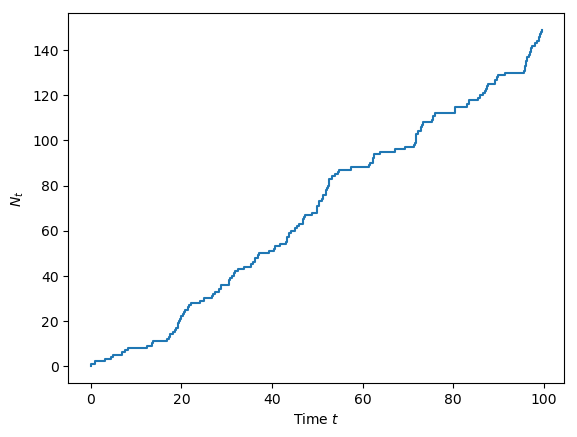

In [19]:
plot_counting_process(hawkes_realisation)

In [20]:
data = {
    "N" : N,
    "events_list" : hawkes_realisation,
    "max_T" : max_T
}

inits = {"mu": 0.5, "alpha": 0.5, "delta": 0.5}


In [21]:
warmup=250
fit = model_compiled.sample(data=data,
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits=inits,
                            ## uncomment to see cmd line updates instead of progress bars
                            # refresh=500,
                            # show_console=True,
                            save_warmup=True)

18:13:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

18:14:03 - cmdstanpy - INFO - CmdStan done processing.


In [24]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-79.827000,0.053371,1.183450,-82.088200,-79.523200,-78.49070,491.685,7.49794,0.999113
mu,0.909381,0.005087,0.153203,0.656431,0.908260,1.16279,907.113,13.83300,1.002470
alpha,0.809768,0.007832,0.240900,0.441938,0.783625,1.21874,946.164,14.42850,0.999221
delta,2.044670,0.018332,0.593007,1.201700,1.973980,3.12697,1046.360,15.95650,1.000090
hawkes_log_likelihood,-80.003900,0.044470,1.026010,-81.965700,-79.779400,-78.81630,532.308,8.11742,0.999719


In [25]:
print(fit.diagnose())

Processing csv files: C:\Users\ethan\AppData\Local\Temp\tmp08w2n3jd\simple_exp_hawkes_v2h93f0odj\simple_exp_hawkes_v2-20240410181326_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\AppData\Local\Temp\tmp08w2n3jd\simple_exp_hawkes_v2h93f0odj\simple_exp_hawkes_v2-20240410181326_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [22]:
df = fit.draws_pd(inc_warmup=True)
# df = fit.draws_pd()

In [23]:
df.head()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,alpha,delta,hawkes_log_likelihood
0,1.0,1.0,1.0,-84.4145,0.675187,0.125000,2.0,3.0,0.0,88.8003,0.692503,0.299256,0.670711,-81.6324
1,1.0,2.0,2.0,-84.4145,0.000000,7.969740,0.0,1.0,1.0,84.8171,0.692503,0.299256,0.670711,-81.6324
2,1.0,3.0,3.0,-84.4145,0.000000,1.130630,0.0,1.0,1.0,85.0488,0.692503,0.299256,0.670711,-81.6324
3,1.0,4.0,4.0,-83.8814,0.999573,0.100911,3.0,7.0,0.0,85.7211,0.983641,0.253395,0.936676,-81.5990
4,1.0,5.0,5.0,-79.7645,0.805866,0.128061,3.0,15.0,0.0,84.9904,0.906497,0.507692,1.441750,-79.1711


In [26]:
log_lik_via_python = []

for index, row in df.iterrows():

    mu = row['mu']
    alpha = row['alpha']
    delta = row['delta']

    params = mu, alpha, delta

    log_lik_via_python.append(log_likelihood(params, [hawkes_realisation, max_T]))

In [27]:
np.allclose(np.array(log_lik_via_python), df['hawkes_log_likelihood'].values)

True

OK! We made a more efficient log likelihood function in Stan. Now big question... will it work for larger max_T?

## Trying larger max_T

In [28]:
hawkes_seed=244659525681607163626346801839259531332

max_T = 200
hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=hawkes_seed)
N = len(hawkes_realisation)

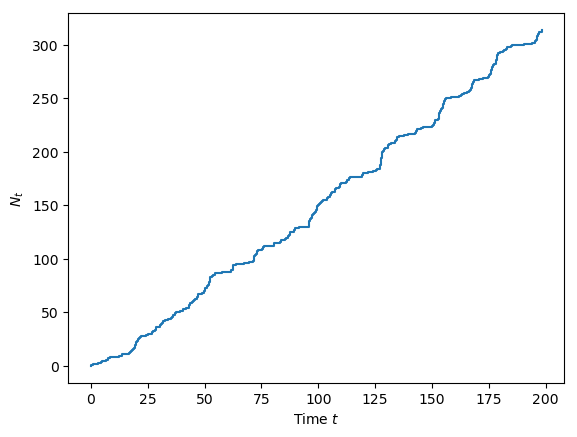

In [29]:
plot_counting_process(hawkes_realisation)

In [30]:
data = {
    "N" : N,
    "events_list" : hawkes_realisation,
    "max_T" : max_T
}

inits = {"mu": 0.5, "alpha": 0.5, "delta": 0.5}


In [31]:
warmup=250
fit = model_compiled.sample(data=data,
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits=inits,
                            ## uncomment to see cmd line updates instead of progress bars
                            # refresh=500,
                            # show_console=True,
                            save_warmup=True)

18:16:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

18:20:44 - cmdstanpy - INFO - CmdStan done processing.


In [32]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-128.831000,0.052633,1.255180,-131.402000,-128.493000,-127.496000,568.704,1.27268,1.00115
mu,0.788694,0.004014,0.104525,0.621565,0.784212,0.976472,677.954,1.51717,1.00610
alpha,1.050780,0.007524,0.197011,0.755002,1.037260,1.389310,685.620,1.53432,1.00117
delta,2.099590,0.015519,0.403186,1.478160,2.084050,2.808470,674.949,1.51044,1.00445
hawkes_log_likelihood,-129.452000,0.049380,1.187190,-131.850000,-129.131000,-128.192000,578.015,1.29352,1.00151


In [33]:
print(fit.diagnose())

Processing csv files: C:\Users\ethan\AppData\Local\Temp\tmp08w2n3jd\simple_exp_hawkes_v29oe8asw2\simple_exp_hawkes_v2-20240410181604_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\AppData\Local\Temp\tmp08w2n3jd\simple_exp_hawkes_v29oe8asw2\simple_exp_hawkes_v2-20240410181604_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [34]:
df = fit.draws_pd(inc_warmup=True)
# df = fit.draws_pd()

In [35]:
df.head()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,alpha,delta,hawkes_log_likelihood
0,1.0,1.0,1.0,-144.069,1.000000,0.062500,2.0,3.0,0.0,153.351,0.433366,0.427615,0.592411,-141.381
1,1.0,2.0,2.0,-144.069,0.000000,14.385500,0.0,1.0,1.0,144.440,0.433366,0.427615,0.592411,-141.381
2,1.0,3.0,3.0,-144.069,0.000000,2.431170,0.0,1.0,1.0,144.104,0.433366,0.427615,0.592411,-141.381
3,1.0,4.0,4.0,-138.115,0.333333,0.239791,2.0,3.0,0.0,142.699,0.783813,0.408613,0.805182,-136.092
4,1.0,5.0,5.0,-134.081,0.997578,0.048280,3.0,7.0,0.0,140.183,0.600790,0.558383,0.966945,-132.753


In [36]:
log_lik_via_python = []

for index, row in df.iterrows():

    mu = row['mu']
    alpha = row['alpha']
    delta = row['delta']

    params = mu, alpha, delta

    log_lik_via_python.append(log_likelihood(params, [hawkes_realisation, max_T]))

In [37]:
np.allclose(np.array(log_lik_via_python), df['hawkes_log_likelihood'].values)

True

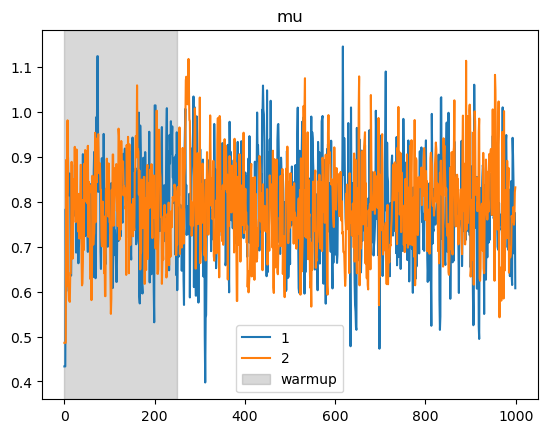

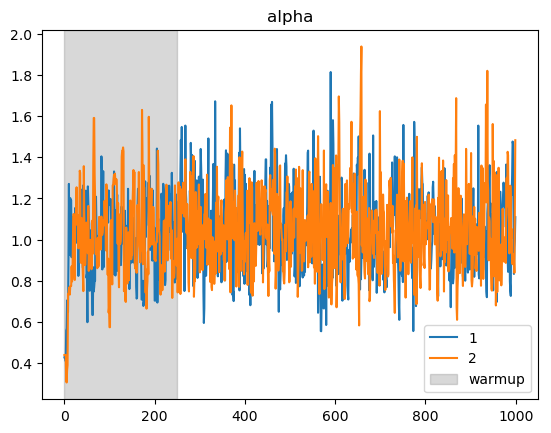

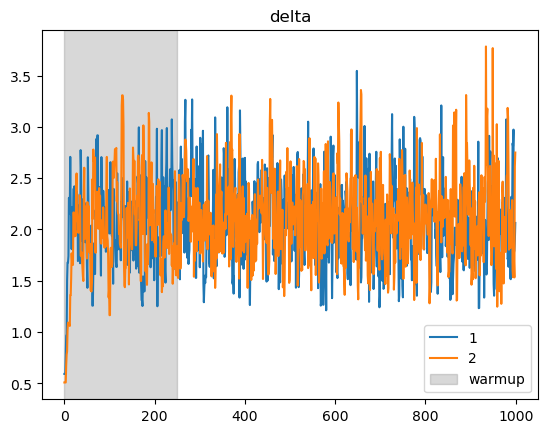

In [38]:
df_chain1 = df[df['chain__'] == 1.0]
df_chain2 = df[df['chain__'] == 2.0]

plt.figure()
plt.plot(df_chain1['mu'].values, label=1)
plt.plot(df_chain2['mu'].values, label=2)
plt.axvspan(xmin=0, xmax=warmup, color='gray', alpha=0.3, label='warmup')
plt.legend()
plt.title('mu')
plt.show()

plt.figure()
plt.plot(df_chain1['alpha'].values, label=1)
plt.plot(df_chain2['alpha'].values, label=2)
plt.axvspan(xmin=0, xmax=warmup, color='gray', alpha=0.3, label='warmup')
plt.legend()
plt.title('alpha')
plt.show()

plt.figure()
plt.plot(df_chain1['delta'].values, label=1)
plt.plot(df_chain2['delta'].values, label=2)
plt.axvspan(xmin=0, xmax=warmup, color='gray', alpha=0.3, label='warmup')
plt.legend()
plt.title('delta')
plt.show()

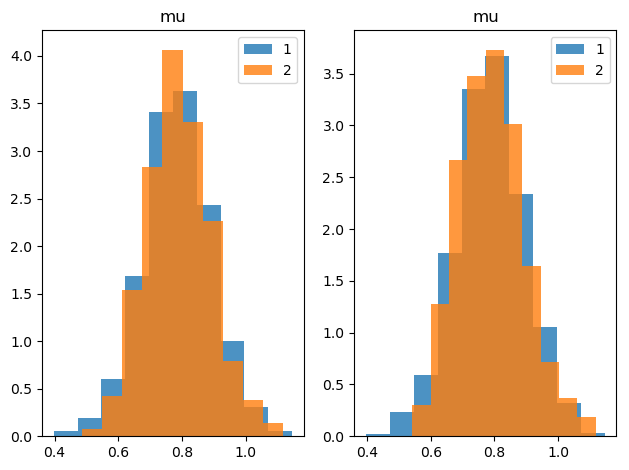

DescribeResult(nobs=1500, minmax=(0.397636, 1.14576), mean=0.7886938046666667, variance=0.010925506427256685, skewness=0.13222770757533406, kurtosis=0.15841569916105813)


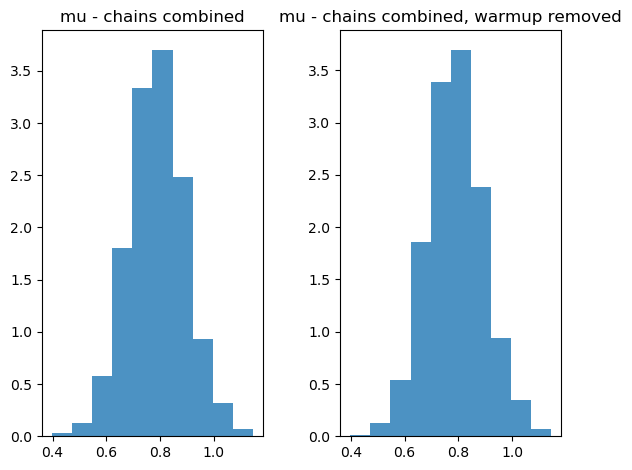

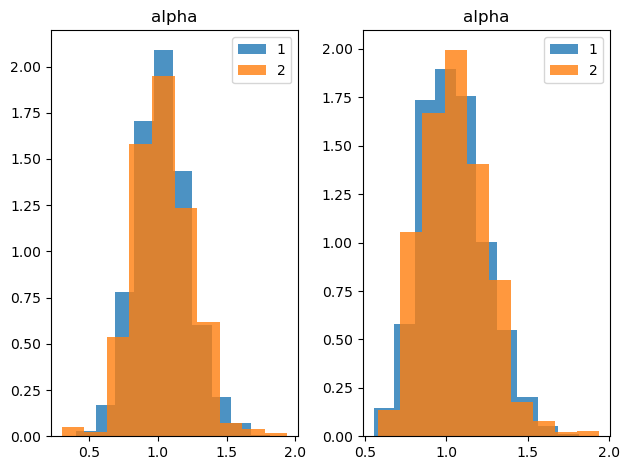

DescribeResult(nobs=1500, minmax=(0.554595, 1.93868), mean=1.050783834, variance=0.038813267998861686, skewness=0.48892519945096274, kurtosis=0.4398099830898472)


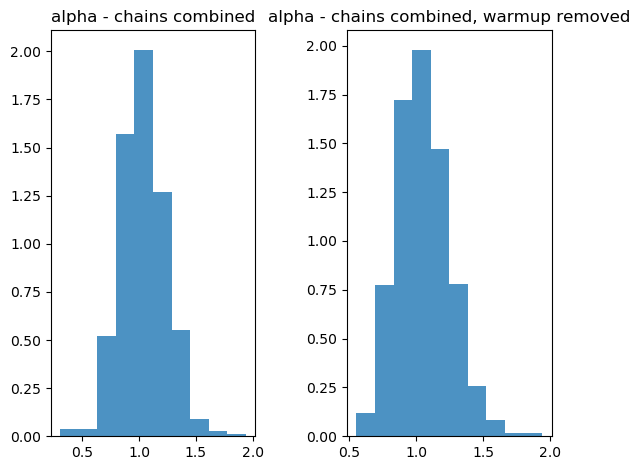

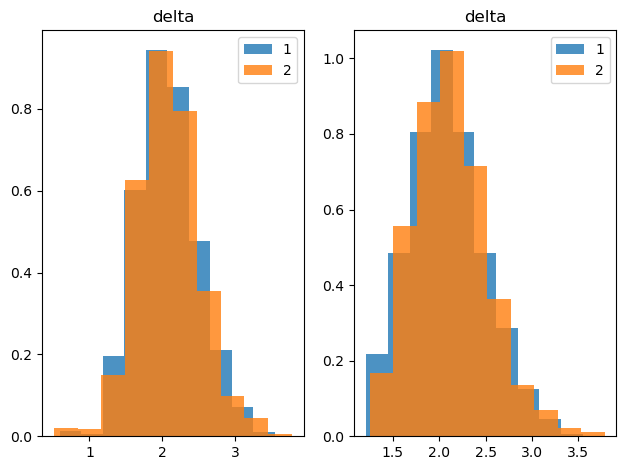

DescribeResult(nobs=1500, minmax=(1.21254, 3.78323), mean=2.0995870733333333, variance=0.16255882355507134, skewness=0.43111079960426285, kurtosis=0.24822781856449083)


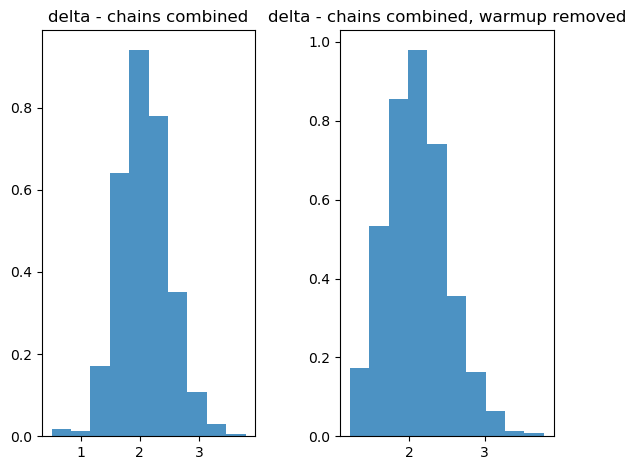

In [40]:
for param_string in ['mu', 'alpha', 'delta']:
    plt.subplot(1, 2, 1)
    plt.hist(df_chain1[param_string].values, alpha=0.8, density=True, label="1")
    plt.hist(df_chain2[param_string].values, alpha=0.8, density=True, label="2")
    plt.legend()
    plt.title(param_string)

    plt.subplot(1, 2, 2)
    plt.hist(df_chain1[param_string].values[warmup:], alpha=0.8, density=True, label="1")
    plt.hist(df_chain2[param_string].values[warmup:], alpha=0.8, density=True, label="2")
    plt.title(param_string)
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.subplot(1, 2, 1)
    plt.hist(df[param_string].values, alpha=0.8, density=True)
    plt.title(f'{param_string} - chains combined')

    plt.subplot(1, 2, 2)
    plt.hist(df[df['iter__']>warmup][param_string].values, alpha=0.8, density=True)
    plt.title(f'{param_string} - chains combined, warmup removed')

    print(describe(df[df['iter__']>warmup][param_string].values))

    plt.tight_layout()
    plt.show()

Now even larger

In [42]:
hawkes_seed=244659525681607163626346801839259531332

max_T = 300
hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=hawkes_seed)
N = len(hawkes_realisation)

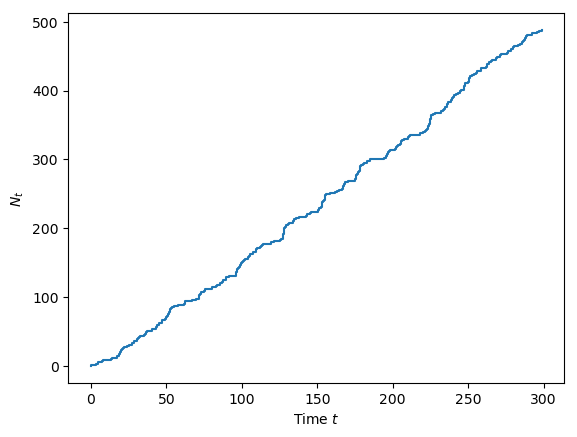

In [43]:
plot_counting_process(hawkes_realisation)

In [44]:
data = {
    "N" : N,
    "events_list" : hawkes_realisation,
    "max_T" : max_T
}

inits = {"mu": 0.5, "alpha": 0.5, "delta": 0.5}


In [45]:
warmup=250
fit = model_compiled.sample(data=data,
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits=inits,
                            ## uncomment to see cmd line updates instead of progress bars
                            # refresh=500,
                            # show_console=True,
                            save_warmup=True)

18:24:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

18:36:48 - cmdstanpy - INFO - CmdStan done processing.


max T 100, 00:37
max T 200, 04:40
max T 300, 11:50

likely unfeasible for max T 1000

In [46]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-190.15800,0.058018,1.261760,-192.760000,-189.81700,-188.82800,472.963,0.435718,1.002280
mu,0.87777,0.002891,0.087997,0.729247,0.87927,1.02309,926.526,0.853564,0.999608
alpha,1.11166,0.007087,0.179591,0.840947,1.09450,1.41544,642.126,0.591560,1.002600
delta,2.41827,0.016951,0.411320,1.809370,2.38571,3.15188,588.771,0.542407,1.001210
hawkes_log_likelihood,-190.91400,0.051624,1.156760,-193.356000,-190.59500,-189.70700,502.085,0.462547,1.002860


In [47]:
print(fit.diagnose())

Processing csv files: C:\Users\ethan\AppData\Local\Temp\tmp08w2n3jd\simple_exp_hawkes_v2xnfyrzaf\simple_exp_hawkes_v2-20240410182458_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\AppData\Local\Temp\tmp08w2n3jd\simple_exp_hawkes_v2xnfyrzaf\simple_exp_hawkes_v2-20240410182458_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [48]:
df = fit.draws_pd(inc_warmup=True)
# df = fit.draws_pd()

In [49]:
df.head()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,alpha,delta,hawkes_log_likelihood
0,1.0,1.0,1.0,-217.706,1.000000,0.062500,2.0,3.0,0.0,226.777,0.398958,0.393611,0.648566,-215.062
1,1.0,2.0,2.0,-217.706,0.000000,14.385500,0.0,1.0,1.0,218.076,0.398958,0.393611,0.648566,-215.062
2,1.0,3.0,3.0,-217.706,0.000000,2.431170,0.0,1.0,1.0,217.741,0.398958,0.393611,0.648566,-215.062
3,1.0,4.0,4.0,-217.706,0.000000,0.239791,0.0,1.0,1.0,218.637,0.398958,0.393611,0.648566,-215.062
4,1.0,5.0,5.0,-210.074,0.973851,0.018627,5.0,31.0,0.0,222.594,0.450615,0.474737,0.707236,-207.859


In [50]:
log_lik_via_python = []

for index, row in df.iterrows():

    mu = row['mu']
    alpha = row['alpha']
    delta = row['delta']

    params = mu, alpha, delta

    log_lik_via_python.append(log_likelihood(params, [hawkes_realisation, max_T]))

In [51]:
np.allclose(np.array(log_lik_via_python), df['hawkes_log_likelihood'].values)

True

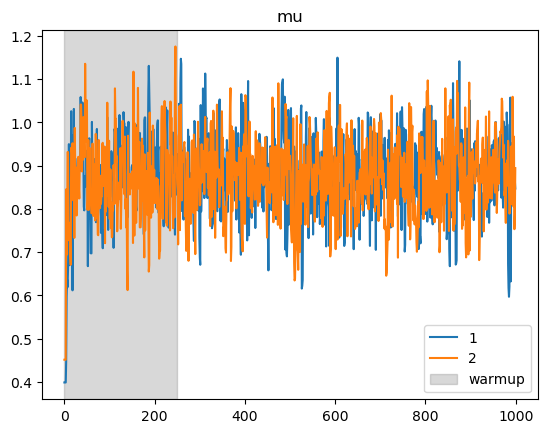

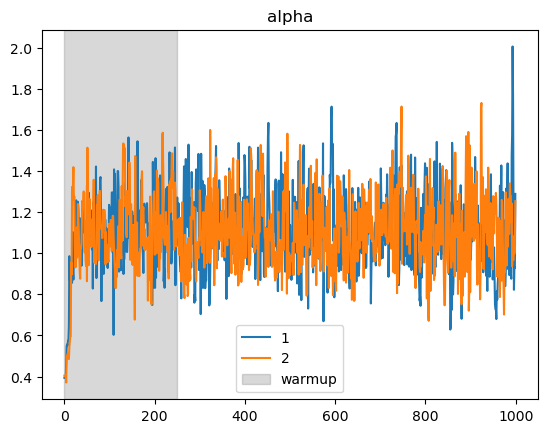

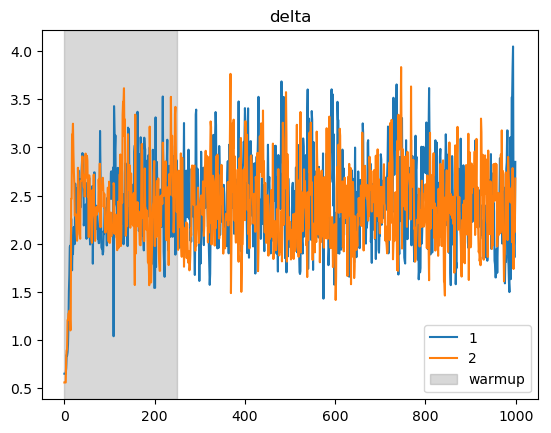

In [52]:
df_chain1 = df[df['chain__'] == 1.0]
df_chain2 = df[df['chain__'] == 2.0]

plt.figure()
plt.plot(df_chain1['mu'].values, label=1)
plt.plot(df_chain2['mu'].values, label=2)
plt.axvspan(xmin=0, xmax=warmup, color='gray', alpha=0.3, label='warmup')
plt.legend()
plt.title('mu')
plt.show()

plt.figure()
plt.plot(df_chain1['alpha'].values, label=1)
plt.plot(df_chain2['alpha'].values, label=2)
plt.axvspan(xmin=0, xmax=warmup, color='gray', alpha=0.3, label='warmup')
plt.legend()
plt.title('alpha')
plt.show()

plt.figure()
plt.plot(df_chain1['delta'].values, label=1)
plt.plot(df_chain2['delta'].values, label=2)
plt.axvspan(xmin=0, xmax=warmup, color='gray', alpha=0.3, label='warmup')
plt.legend()
plt.title('delta')
plt.show()

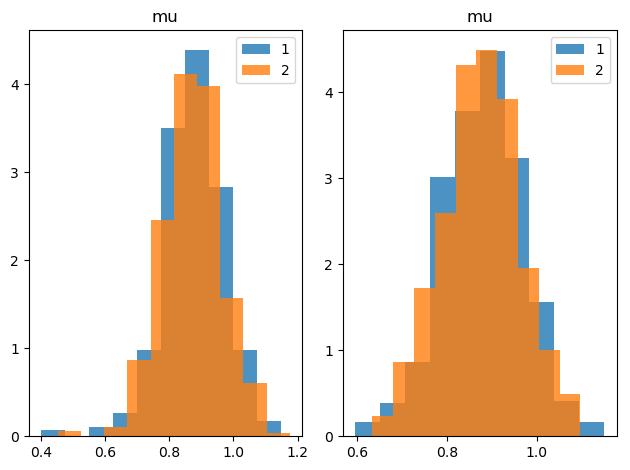

DescribeResult(nobs=1500, minmax=(0.597058, 1.14976), mean=0.8777702433333334, variance=0.007743531402429742, skewness=-0.05516346477775478, kurtosis=0.0029215032166232113)


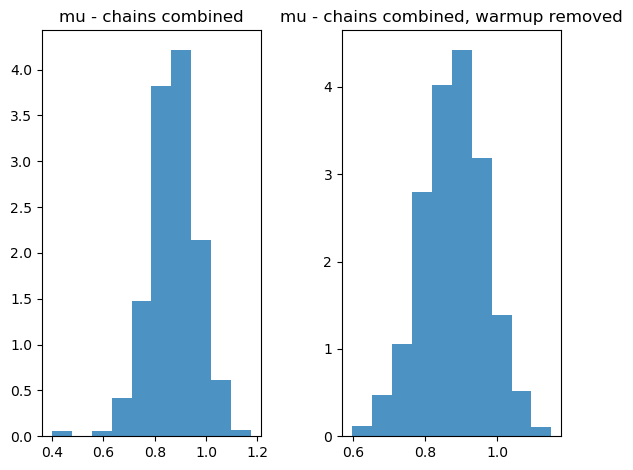

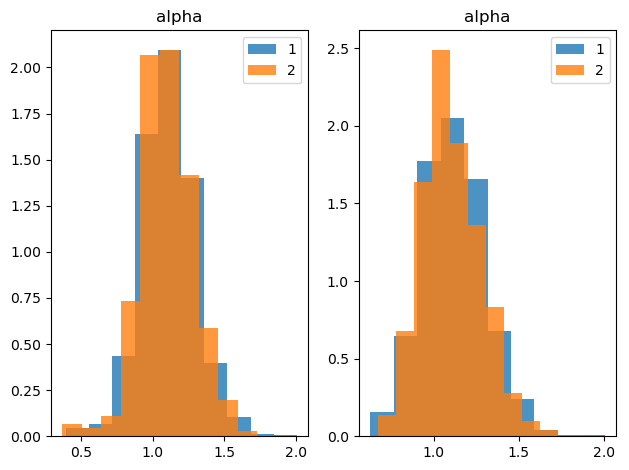

DescribeResult(nobs=1500, minmax=(0.62836, 2.00588), mean=1.1116616686666667, variance=0.032253024366820766, skewness=0.3997142024260028, kurtosis=0.3944618234457691)


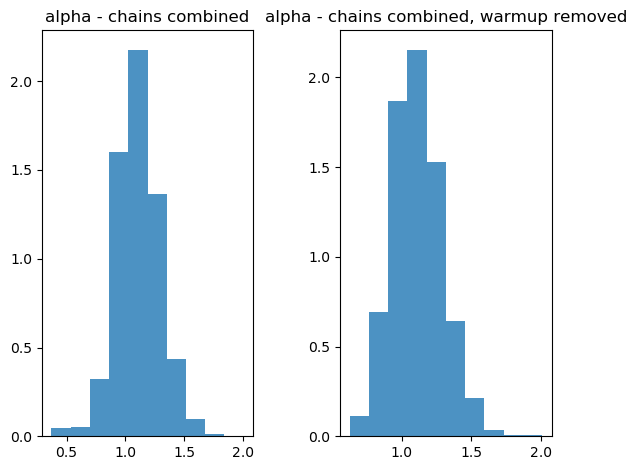

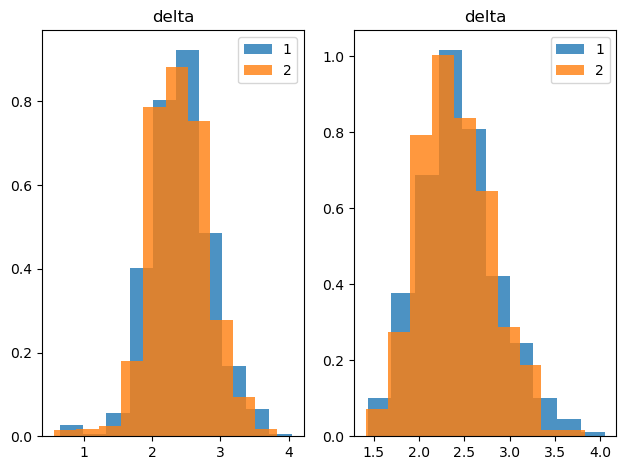

DescribeResult(nobs=1500, minmax=(1.41455, 4.0489), mean=2.4182708199999996, variance=0.169183869736552, skewness=0.43398725705394686, kurtosis=0.11260065013496412)


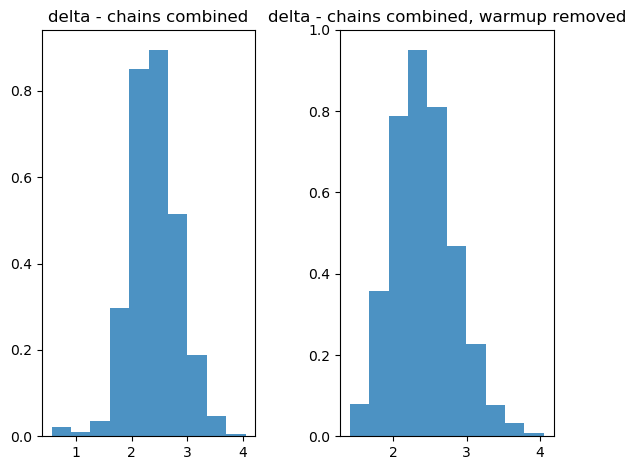

In [53]:
for param_string in ['mu', 'alpha', 'delta']:
    plt.subplot(1, 2, 1)
    plt.hist(df_chain1[param_string].values, alpha=0.8, density=True, label="1")
    plt.hist(df_chain2[param_string].values, alpha=0.8, density=True, label="2")
    plt.legend()
    plt.title(param_string)

    plt.subplot(1, 2, 2)
    plt.hist(df_chain1[param_string].values[warmup:], alpha=0.8, density=True, label="1")
    plt.hist(df_chain2[param_string].values[warmup:], alpha=0.8, density=True, label="2")
    plt.title(param_string)
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.subplot(1, 2, 1)
    plt.hist(df[param_string].values, alpha=0.8, density=True)
    plt.title(f'{param_string} - chains combined')

    plt.subplot(1, 2, 2)
    plt.hist(df[df['iter__']>warmup][param_string].values, alpha=0.8, density=True)
    plt.title(f'{param_string} - chains combined, warmup removed')

    print(describe(df[df['iter__']>warmup][param_string].values))

    plt.tight_layout()
    plt.show()